In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import randrange
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams.update({'font.size': 22})

# Task 2 Compete in a kaggle competition to predict Titanic Survival

#### SibSp
number of siblings/spouses on board<br>
Sibling = brother sister stepbrother stepsister<br>
spouse = husband, wife (mistresses and fiancés were ignored)

#### Parch
number of parents/children<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
some children travelled only with a nanny, parch=0 for them

#### Class
proxy for socio-economic status 1=upper, 2=middle, 3=lower

#### Survived
1 = Yes, 0 = No

#### Embarked
C = Cherbourg, Q=Queenstown, S=Southampton

### Task 2A: Preparation

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

display(train_df.head())
display(test_df.head())
display(train_df.describe())
display(test_df.describe())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


0      X
1      C
2      X
3      C
4      X
      ..
886    X
887    B
888    X
889    C
890    X
Name: Room_letter, Length: 891, dtype: object


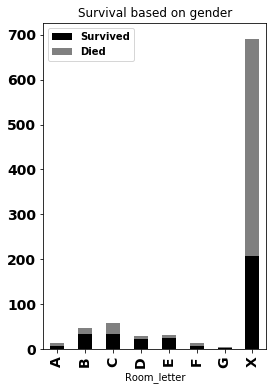

In [37]:
# Data bekjken (Lotte) - lelijkste code ooit!! Heb enorm rondgeklooid haha
#for col in train_df:
#    print(f"Column name: {train_df[col]} data type: {train_df[col].dtypes} distinct values: {train_df[col].unique()}")

roomletters = []
# print(train_df['Cabin'].unique())
#counter = 0
for room in train_df['Cabin']:
    if room != room:
        roomletters.append('X')
    elif len(str(room)) < 2:
        roomletters.append('X')
    else:
        roomletters.append(str(room)[0])

train_df['Died'] = 1 - train_df['Survived']
train_df['Room_letter'] = roomletters
print(train_df['Room_letter'])
plot = train_df.groupby('Room_letter').agg('sum')[['Survived', 'Died']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(4, 6),
                                                                    stacked=True, 
                                                                    color=['black', 'grey'],
                                                                    title="Survival based on gender");
plot.figure.savefig("results/roomletter")

# train_df['Died'] = 1 - train_df['Survived']
# # alldata = train_df.groupby('Sex').agg('sum')[['Survived', 'Died']]
# plt.style.use('seaborn')

# plot = train_df.groupby('Fare').agg('sum')[['Survived', 'Died']].plot(kind='bar', 
#                                                                     fontsize=14, 
#                                                                     figsize=(4, 6),
#                                                                     stacked=False, 
#                                                                     color=['black', 'grey'],
#                                                                     title="Survival based on place of embarkment");
# # plot.figure.savefig("results/embark")
#plt.hist(train_df['SibSp'])
# plot = train_df['Fare'].plot(kind='hist', fontsize=14, figsize=(4, 6),stacked=False, title="Fare");
# plot.figure.savefig("results/Fare_histo")
# plt.plot(train_df['Fare'],train_df['Survived'])
# plot = train_df['Age'].plot(kind='hist', fontsize=14, figsize=(4, 6),stacked=False, color=['black','grey']title="Age");
# plot.figure.savefig("results/Age_box")
# import scipy.stats as stats
# import statsmodels.api as sm
# x = train_df[['Pclass', 'Fare']]
# y = train_df['Survived']

# results = sm.OLS(y,x).fit()
# results.summary()

# import numpy as np

# r = np.corrcoef(train_df[['Pclass', 'Fare']],rowvar=False)
# print(r)

# import scipy.stats as st
# print(st.pointbiserialr(train_df['Pclass'], train_df['Fare']))

# print(train_df['Fare'].unique())

# import numpy as np
# from scipy.stats import kruskal

# #cont_table=pd.pivot_table(train_df,index=[‘Hair’],columns=[‘Eye’],aggfunc=np.sum)
# print(kruskal(train_df['Pclass'], train_df['Fare'],nan_policy='omit'))


Survived: int64, [0,1]

Pclass: int64, [3,1,2]

Name: __weghalen__

Sex: object (= string?), [male,female]

Age: float 64, soms NaN data, nog naar distributie kijken, en waarom is dit een float? hoe kan je 0.67 zijn?

Sibsp: int64, [1,0,3,4,2,5,8]

Parch: int64, [0,1,2,3,4,5,6]

Ticket: object(string?),  __weghalen?__

Fare(tarief): float64, duurdere tickets is betere kamer? verband met cabin & pclass bekijken.

Cabin: object(string?), er zijn missing values (nan), cabin nr bestaat uit: [letter,cijfer,(cijfer),(cijfer)]. Kamerletters zijn: {'G', 'F', 'D', 'T', 'C', 'A', 'E', 'B'} (op volgorde: A,B,C,D,E,F,G,T). Maar, sommige mensen hebben meerdere cabins:'D10 D12' en 'B51 B53 B55' of een kamernummer met alleen een letter 'D'. Hoe eerder in het alfabet de letter van je kamer, hoe hoger de verdieping waarop je slaapt. Kijken naar verband met Pclass: mensen met meer geld slapen misschien op bepaalde verdiepingen? En hogere verdieping is hogere kans op overleven?

Embarked: object(string), [S,C,Q,nan] & [644,168,77,2] dus er zijn 2 missing values

Died: explicit relation met survived, toch? even checken of de data overeen komt. [0,1]: gecheckt, iedereen die overleefd heeft is niet dood en iedereen die niet overleefd heeft is wel dood. dus __weghalen?__

### Plotjes

In [ ]:
import os
if not os.path.exists('results/titanic/'):
    os.makedirs('results/titanic/')
    
from collections import Counter


def show_save_histogram(df, column_name):
    """ Makes and saves a histogram of a specific df column. """
    train_df.hist(column=column_name)
    plt.savefig("results/titanic/" + column_name + ".png")

def make_bar_chart(df, column_name):
    """ Makes a bar chart given a data frame column. """
    
    freqs = Counter(df[column_name])
    xvals = range(len(freqs.values()))
    
    plt.figure()
    plt.bar(xvals, freqs.values())
    plt.xticks(xvals, freqs.keys())
    
    plt.savefig("results/titanic/" + column_name + ".png")


make_bar_chart(train_df, "Sex")
make_bar_chart(train_df, "Embarked")
make_bar_chart(train_df, "Cabin")

In [ ]:
train_df['Died'] = 1 - train_df['Survived']
alldata = train_df.groupby('Sex').agg('sum')[['Survived', 'Died']]
plt.style.use('seaborn')

print(alldata)
plot = train_df.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(4, 6),
                                                                    stacked=False, 
                                                                    color=['black', 'grey'],
                                                                    title="Survival based on gender");
plot.figure.savefig("results/gender")

In [ ]:
# g = sns.FacetGrid(train_df, col='Survived', height=5, aspect=.9, col_order=[1, 0])
# g.map(plt.hist, 'Age', bins=25, color='black')
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Survival based on age', fontsize=16)
# g.savefig("results/age")

figure = plt.figure(figsize=(6, 6))
plt.hist([data[data['Survived'] == 1]['Age'], data[data['Survived'] == 0]['Age']], 
         stacked=True, color = ['black','grey'],
         bins = 25, label = ['Survived','Dead'])
plt.title('Survival based on age')
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend();
plt.savefig("results/agestacked")

In [ ]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Fare', bins=20)

g = sns.FacetGrid(train_df, col='Survived', height=5, aspect=.9, col_order=[1, 0])
g.map(plt.hist, 'Fare', bins=25, color='black')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survival based on fare', fontsize=16)
# g.savefig("results/age")

### Task 2B: Classification and Evaluation

#### Random solution

In [ ]:
# Random solution to titanic kaggle competition

# Create basis for dataframe
random_data = {'PassengerId': [], 'Survived':[]}

# Iterate over test data
for index,row in test_df.iterrows():

    # Append Passenger ID
    random_data['PassengerId'].append(row['PassengerId'])
    
    # Append random survival value from (0,1)
    random_data['Survived'].append(randrange(2))

# Make pandas dataframe
df_random_solution = pd.DataFrame(random_data)

# Save solution as csv
df_random_solution.to_csv('results/randomsol.csv', index=False)

#### Non-random solution

In [ ]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# Trainingset: Preprocess data
train_df.info()

#### It is clear that some data is missing for 'age', 'cabin' and 'embarked'. Cabin has too little data, so it is dropped from the dataset. Name and ticket seem to not be relevant.

In [ ]:
# Drop from training and test set
try: 
    train_df = train_df.drop(['Ticket', 'Cabin', 'Name'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin', 'Name'], axis=1)
except KeyError:
    print("Already deleted columns")
train_df.head(15)

#### From the plots of survived people in a specific age category, it seems that the most people between 20 and 30 did not survive. 

In [ ]:
# Obtain 4 category's for age
train_df['age_category'] = pd.cut(train_df['Age'], 5)

# Fill missing value with mean age
mean_age = train_df.Age.dropna().mean()
train_df.Age.fillna(mean_age, inplace=True)
test_df.Age.fillna(mean_age, inplace=True)

# Change in both datasets
train_df.loc[ train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age'] = 1
train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age'] = 2
train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age'] = 3
train_df.loc[ train_df['Age'] > 64, 'Age'] = 4

test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[ test_df['Age'] > 64, 'Age'] = 4

train_df.head(10)

# Drop age category from dataframe
train_df.drop(columns=['age_category'], axis=1, inplace=True)

In [ ]:
# Convert sex to only have zeros and ones
train_df['Sex'] = train_df['Sex'].map({'female': 1, 'male': 0})
test_df['Sex'] = test_df['Sex'].map({'female': 1, 'male': 0})

train_df.head()

In [ ]:
# Preprocess embarked

# Get mode for missing values
mode = train_df.Embarked.dropna().mode()[0]

 # Fill missing values with mode
train_df['Embarked'] = train_df['Embarked'].fillna(mode)
test_df['Embarked'] = test_df['Embarked'].fillna(mode)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Convert to integers
train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_df['Embarked'] = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

#### Process fare information

In [ ]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Fare', bins=20)

#### It seems like survivalrate is small when fare rate was little and that survival rate is higher when fare rate is very high. 

In [ ]:
# First, fill in missing values with the median
median_fare = test_df['Fare'].dropna().median()
test_df['Fare'].fillna(median_fare, inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 3)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

# Categorize
train_df.loc[ (train_df['Fare'] <= 8.662) & (train_df['Fare'] > 0.0), 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 8.662) & (train_df['Fare'] <= 26.0), 'Fare'] = 1
train_df.loc[ train_df['Fare'] > 26.0, 'Fare'] = 3

test_df.loc[ (test_df['Fare'] <= 8.662) & (test_df['Fare'] > 0.0), 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 8.662) & (test_df['Fare'] <= 26.0), 'Fare'] = 1
test_df.loc[ test_df['Fare'] > 26.0, 'Fare'] = 3

# Drop fareband from dataset
train_df = train_df.drop(['FareBand'], axis=1)

In [ ]:
for column in train_df:
    train_df[column].astype(int)

train_df.head(10)

In [ ]:
X_train = train_df.drop("Survived", axis=1).copy()
X_train = X_train.drop("PassengerId", axis=1).copy()
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

# Random forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest